In [1]:
#instalka pythona 3.10 pod collaba xd
!wget https://www.python.org/ftp/python/3.10.13/Python-3.10.13.tgz
!tar xvf Python-3.10.13.tgz
%cd Python-3.10.13
!./configure
!make
!sudo make install


Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
Compiling '/usr/local/lib/python3.10/test/_test_embed_set_config.py'...
Compiling '/usr/local/lib/python3.10/test/_test_multiprocessing.py'...
Compiling '/usr/local/lib/python3.10/test/_typed_dict_helper.py'...
Compiling '/usr/local/lib/python3.10/test/ann_module.py'...
Compiling '/usr/local/lib/python3.10/test/ann_module2.py'...
Compiling '/usr/local/lib/python3.10/test/ann_module3.py'...
Compiling '/usr/local/lib/python3.10/test/ann_module4.py'...
Compiling '/usr/local/lib/python3.10/test/ann_module5.py'...
Compiling '/usr/local/lib/python3.10/test/ann_module6.py'...
Compiling '/usr/local/lib/python3.10/test/ann_module7.py'...
Compiling '/usr/local/lib/python3.10/test/audiotests.py'...
Compiling '/usr/local/lib/python3.10/test/audit-tests.py'...
Compiling '/usr/local/lib/python3.10/test/autotest.py'...
Compiling '/usr/local/lib/python3.10/test/bad_getattr.py'...
Compiling '/usr/local/lib/python3.10/test/bad_getattr2.py'

In [2]:
!python --version


Python 3.10.13


In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import zipfile
import os

from sklearn.model_selection import RandomizedSearchCV

In [4]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
with zipfile.ZipFile('UCI HAR Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

--2025-03-31 14:52:59--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip     [    <=>             ]  58.17M  82.0MB/s    in 0.7s    

2025-03-31 14:53:00 (82.0 MB/s) - ‘UCI HAR Dataset.zip’ saved [60999314]



In [5]:
train_data = pd.read_csv('./UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None)
train_labels = pd.read_csv('./UCI HAR Dataset/train/y_train.txt', delim_whitespace=True, header=None)

test_data = pd.read_csv('./UCI HAR Dataset/test/X_test.txt', delim_whitespace=True, header=None)
test_labels = pd.read_csv('./UCI HAR Dataset/test/y_test.txt', delim_whitespace=True, header=None)


<ipython-input-5-5cd4ad5c4b76>:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_data = pd.read_csv('./UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None)
<ipython-input-5-5cd4ad5c4b76>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_labels = pd.read_csv('./UCI HAR Dataset/train/y_train.txt', delim_whitespace=True, header=None)
<ipython-input-5-5cd4ad5c4b76>:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_data = pd.read_csv('./UCI HAR Dataset/test/X_test.txt', delim_whitespace=True, header=None)
<ipython-input-5-5cd4ad5c4b76>:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'``

In [6]:
print("Rozmiar danych treningowych:", train_data.shape)
print("Rozmiar danych testowych:", test_data.shape)

Rozmiar danych treningowych: (7352, 561)
Rozmiar danych testowych: (2947, 561)


In [7]:
# Tuning hiperparametrów

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                                   n_iter=20, cv=3, verbose=2, n_jobs=-1)

random_search.fit(train_data, train_labels.values.ravel())
print("Najlepsze parametry:", random_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Najlepsze parametry: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 20}


In [16]:
# Model z najlepszymi parametrami

best_rf = RandomForestClassifier(
    n_estimators=200,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='log2',
    max_depth=20,
    random_state=42,
    n_jobs=-1  # przyspiesza trenowanie na wielu rdzeniach
)

best_rf.fit(train_data, train_labels.values.ravel())

y_pred = best_rf.predict(test_data)

from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(test_labels, y_pred))


Accuracy: 0.9385816084153377


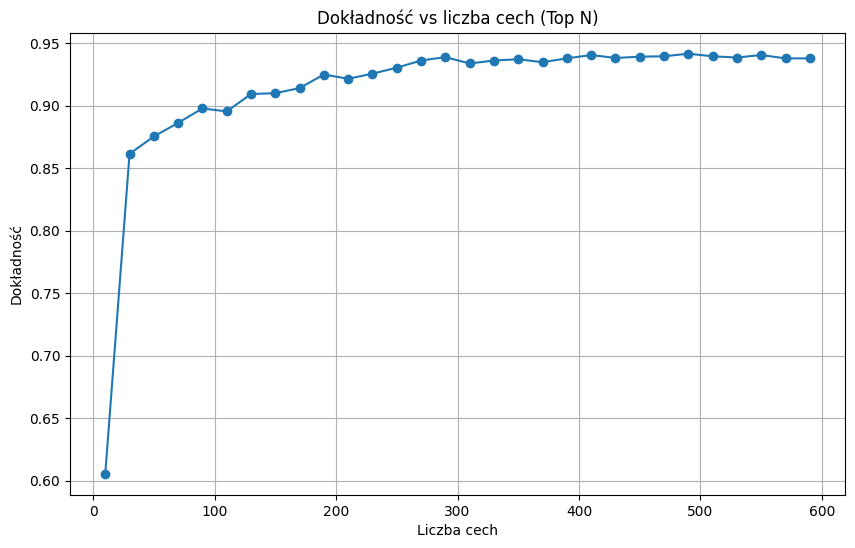

In [25]:
# Feature Selection

import matplotlib.pyplot as plt

accuracies = []
feature_counts = list(range(10, 600, 20))

importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

for top_n in feature_counts:
    X_train_sel = train_data.iloc[:, indices[:top_n]]
    X_test_sel = test_data.iloc[:, indices[:top_n]]

    model = RandomForestClassifier(
        n_estimators=200,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='log2',
        max_depth=20,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train_sel, train_labels.values.ravel())
    y_pred = model.predict(X_test_sel)
    acc = accuracy_score(test_labels, y_pred)
    accuracies.append(acc)

# 📈 Rysujemy wykres
plt.figure(figsize=(10, 6))
plt.plot(feature_counts, accuracies, marker='o')
plt.title("Dokładność vs liczba cech (Top N)")
plt.xlabel("Liczba cech")
plt.ylabel("Dokładność")
plt.grid(True)
plt.show()


In [21]:
# Feature Selection

importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 400  # np. top 50

X_train_selected = train_data.iloc[:, indices[:top_n]]
X_test_selected = test_data.iloc[:, indices[:top_n]]

rf_selected = RandomForestClassifier(**random_search.best_params_)
rf_selected.fit(X_train_selected, train_labels.values.ravel())

y_pred = rf_selected.predict(X_test_selected)
print("Dokładność po selekcji cech:", accuracy_score(test_labels, y_pred))


Dokładność po selekcji cech: 0.9362063115032236


In [11]:
#y_pred = rf_model.predict(test_data)
y_pred = random_search.predict(test_data)

print("\n🎯 Accuracy:", accuracy_score(test_labels, y_pred))
print("\n📊 Classification Report:\n", classification_report(test_labels, y_pred))
print("\n🟦 Confusion Matrix:\n", confusion_matrix(test_labels, y_pred))


🎯 Accuracy: 0.9385816084153377

📊 Classification Report:
               precision    recall  f1-score   support

           1       0.91      0.97      0.94       496
           2       0.90      0.93      0.92       471
           3       0.96      0.85      0.90       420
           4       0.98      0.88      0.92       491
           5       0.90      0.98      0.94       532
           6       1.00      1.00      1.00       537

    accuracy                           0.94      2947
   macro avg       0.94      0.93      0.94      2947
weighted avg       0.94      0.94      0.94      2947


🟦 Confusion Matrix:
 [[481   6   9   0   0   0]
 [ 25 440   6   0   0   0]
 [ 20  44 356   0   0   0]
 [  0   0   0 431  60   0]
 [  0   0   0  11 521   0]
 [  0   0   0   0   0 537]]


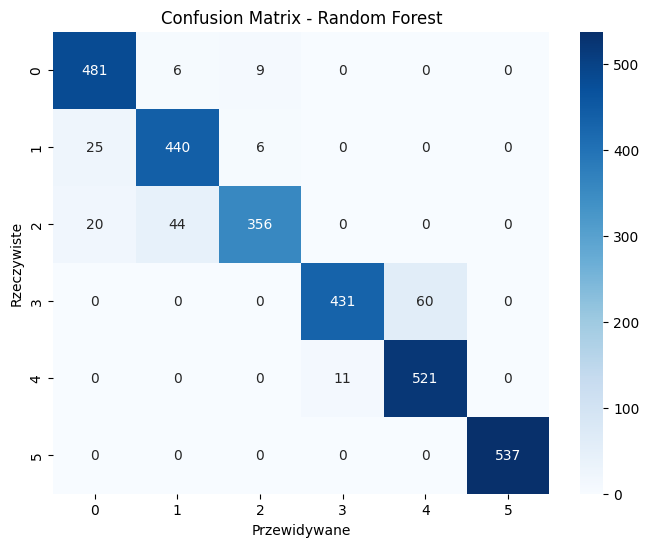

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(test_labels, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.show()